# Bootstrap aggregating(Bagging)
是一種集成學習方法，旨在提高模型的穩定性與準確度，減少過擬合的風險。它透過將訓練數據集進行多次隨機抽樣（有放回的抽樣），並將多個基學習器（例如決策樹）訓練在不同的子集上，最終將所有基學習器的預測結果進行整合。

Number of rows in the dataset: 1728
Distribution of safety ratings:
safety
low     0.333333
med     0.333333
high    0.333333
Name: proportion, dtype: float64
Distribution of safety ratings in bootstrapped sample:
safety
low     0.346065
high    0.337963
med     0.315972
Name: proportion, dtype: float64


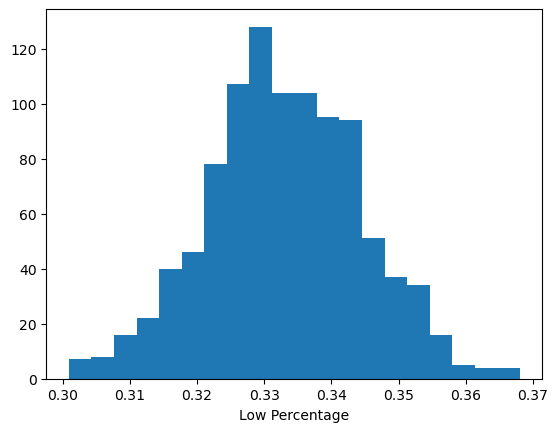

Average low percentage: 0.3330
95% Confidence Interval for low percentage: (0.3096, 0.3553)
Accuracy of decision tree trained on the full training set: 0.8588
Accuracy of decision tree trained on bootstrapped sample: 0.8912
Accuracy of aggregated 10 bootstrapped samples: 0.9097
Accuracy of decision tree trained on the full feature set: 0.9444
Accuracy of decision tree trained on random sample of 10 features: 0.7523
Accuracy of aggregated 10 random feature samples: 0.7315


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 載入資料集並進行處理
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', 
                 names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])
df['accep'] = ~(df['accep']=='unacc')  # 1為可接受，0為不可接受
X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)  # 將分類變數轉換為虛擬變數
y = df['accep']

# 切分訓練集與測試集
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

# 1. 計算資料集行數以及安全性評分的分佈
nrows = df.shape[0]
print(f'Number of rows in the dataset: {nrows}')
print(f'Distribution of safety ratings:')
print(df.safety.value_counts(normalize=True))

# 2. 建立一個bootstrapped樣本並計算其安全性評分的分佈
boot_sample = df.sample(nrows, replace=True)
print(f'Distribution of safety ratings in bootstrapped sample:')
print(boot_sample.safety.value_counts(normalize=True))

# 3. 建立1000個bootstrapped樣本並計算每個樣本中"low"安全性評分的比例
low_perc = [df.sample(nrows, replace=True).safety.value_counts(normalize=True).get('low', 0) for _ in range(1000)]

# 4. 繪製低比例值的直方圖
plt.hist(low_perc, bins=20)
plt.xlabel('Low Percentage')
plt.show()

# 5. 計算2.5%與97.5%百分位數，並顯示平均值
mean_lp = np.mean(low_perc) 
print(f'Average low percentage: {mean_lp:.4f}')
low_perc.sort()
print(f'95% Confidence Interval for low percentage: ({low_perc[25]:.4f}, {low_perc[975]:.4f})')

# --------------- 第二段程式碼 ---------------
# 訓練一個原始決策樹模型並評估準確度
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(x_train, y_train)
print(f'Accuracy of decision tree trained on the full training set: {dt.score(x_test, y_test):.4f}')

# 2. 使用bootstrapped樣本訓練新決策樹模型
dt2 = DecisionTreeClassifier(max_depth=5)
ids = x_train.sample(x_train.shape[0], replace=True, random_state=0).index
dt2.fit(x_train.loc[ids], y_train.loc[ids])
print(f'Accuracy of decision tree trained on bootstrapped sample: {dt2.score(x_test, y_test):.4f}')

# 3. 執行bootstrapping 10次並聚合結果
preds = []
for i in range(10):
    ids = x_train.sample(x_train.shape[0], replace=True, random_state=0+i).index
    dt2.fit(x_train.loc[ids], y_train.loc[ids])
    preds.append(dt2.predict(x_test))
ba_pred = np.mean(preds, axis=0)

# 4. 計算聚合結果的準確度
ba_accuracy = accuracy_score(ba_pred >= 0.5, y_test)
print(f'Accuracy of aggregated 10 bootstrapped samples: {ba_accuracy:.4f}')

# --------------- 第三段程式碼 ---------------
# 訓練原始決策樹並計算其準確度
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
accuracy_dt = dt.score(x_test, y_test)
print(f'Accuracy of decision tree trained on the full feature set: {accuracy_dt:.4f}')

# 1. 從訓練集中隨機選擇10個特徵
rand_features = np.random.choice(x_train.columns, 10)

# 2. 使用隨機選擇的特徵訓練新的決策樹並計算準確度
dt2 = DecisionTreeClassifier()
dt2.fit(x_train[rand_features], y_train)
accuracy_dt2 = dt2.score(x_test[rand_features], y_test)
print(f'Accuracy of decision tree trained on random sample of 10 features: {accuracy_dt2:.4f}')

# 3. 建立基於隨機特徵樣本的10個決策樹並聚合結果
predictions = []
for i in range(10):
    rand_features = np.random.choice(x_train.columns, 10)
    dt2.fit(x_train[rand_features], y_train)
    predictions.append(dt2.predict(x_test[rand_features]))

# 4. 計算聚合預測的準確度
prob_predictions = np.mean(predictions, axis=0)
agg_predictions = (prob_predictions > 0.5)
agg_accuracy = accuracy_score(agg_predictions, y_test)
print(f'Accuracy of aggregated 10 random feature samples: {agg_accuracy:.4f}')

# Bagging using scikit-learn

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris

# 載入汽車資料集
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', 
                 names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])
df['accep'] = ~(df['accep']=='unacc')  # 1 表示可接受，0 表示不可接受
X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)
y = df['accep']
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

# ================= Bagging Classifier with Decision Trees =================
# 1. 使用 10 個決策樹基模型的 Bagging 分類器
bag_dt = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=10)
bag_dt.fit(x_train, y_train)
print('Accuracy of Bagging Classifier with 10 base models:')
bag_accuracy = bag_dt.score(x_test, y_test)
print(f'Accuracy: {bag_accuracy:.4f}')

# 2. 設定 `max_features` 為 10
bag_dt_10 = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=10, max_features=10)
bag_dt_10.fit(x_train, y_train)
print('Accuracy of Bagging Classifier with max_features=10:')
bag_accuracy_10 = bag_dt_10.score(x_test, y_test)
print(f'Accuracy: {bag_accuracy_10:.4f}')

# 3. 更改基模型為邏輯回歸
bag_lr = BaggingClassifier(estimator=LogisticRegression(), n_estimators=10, max_features=10)
bag_lr.fit(x_train, y_train)
print('Accuracy of Bagging Classifier with Logistic Regression base model:')
bag_accuracy_lr = bag_lr.score(x_test, y_test)
print(f'Accuracy: {bag_accuracy_lr:.4f}')

# ================= Random Forest Classifier =================
# 載入相同的汽車資料集
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', 
                 names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'accep'])
df['accep'] = ~(df['accep']=='unacc')  # 1 表示可接受，0 表示不可接受
X = pd.get_dummies(df.iloc[:,0:6], drop_first=True)
y = df['accep']
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

# 1. 建立隨機森林分類器並顯示其參數
rf = RandomForestClassifier()
print('Random Forest parameters:')
rf_params = rf.get_params()
print(rf_params)

# 2. 訓練隨機森林分類器並計算測試資料集的準確度
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print('Test set accuracy of Random Forest:')
rf_accuracy = rf.score(x_test, y_test)
print(f'Accuracy: {rf_accuracy:.4f}')

# 3. 計算精確度、召回率以及混淆矩陣
rf_precision = precision_score(y_test, y_pred)
print(f'Precision: {rf_precision:.4f}')
rf_recall = recall_score(y_test, y_pred)
print(f'Recall: {rf_recall:.4f}')
rf_confusion_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{rf_confusion_matrix}')

# ================= Random Forest Regressor =================
# 生成一些假價格來進行回歸分析
fake_prices = (15000 + 25*df.index.values) + np.random.normal(size=df.shape[0])*5000
df['price'] = fake_prices
print(df.price.describe())
y = df['price']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

# 1. 建立隨機森林回歸器並顯示訓練和測試資料集上的 `R^2` 分數
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)
r_squared_train = rfr.score(x_train, y_train)
print(f'Training R^2: {r_squared_train:.4f}')

r_squared_test = rfr.score(x_test, y_test)
print(f'Test R^2: {r_squared_test:.4f}')

# 2. 顯示訓練和測試資料集上的平均絕對誤差 (MAE)
avg_price = y.mean()
print(f'Average price (train/test set): {avg_price:.2f}')

y_pred_train = rfr.predict(x_train)
y_pred_test = rfr.predict(x_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
print(f'Training MAE: {mae_train:.2f}')

mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'Test MAE: {mae_test:.2f}')

# ================= Random Forest on Iris Dataset =================
# 載入鳶尾花資料集
data = load_iris()
X, y = data.data, data.target

# 分割資料
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# 建立隨機森林模型
rf_iris = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# 訓練模型
rf_iris.fit(X_train, y_train)

# 預測並評估
y_pred_iris = rf_iris.predict(X_test)
print(f"Accuracy on Iris dataset: {accuracy_score(y_test, y_pred_iris):.2f}")

Accuracy of Bagging Classifier with 10 base models:
Accuracy: 0.9120
Accuracy of Bagging Classifier with max_features=10:
Accuracy: 0.9074
Accuracy of Bagging Classifier with Logistic Regression base model:
Accuracy: 0.8634
Random Forest parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Test set accuracy of Random Forest:
Accuracy: 0.9444
Precision: 0.9242
Recall: 0.8971
Confusion Matrix:
[[286  10]
 [ 14 122]]
count     1728.000000
mean     36616.730436
std      13418.497099
min       5612.149714
25%      25790.827528
50%      36056.502617
75%      47294.002769
max      71763.634205
Name: price, dtype: float64
Training R^2: 0.9752
Test 

In [3]:
import datetime

current_date = datetime.datetime.now().strftime("%Y年%m月%d日")
print(f"更新日期: {current_date}")

更新日期: 2024年12月01日
